Code to prep the data into dataloaders to import into the model

~/data/
    handlers : [handler1, handler2, ...]
    dataloaders : [train_loader_year-month-day, test_loader_year-month-day]

In [1]:
# Packages
from lib.models.EEG_Net_CNN import EEG_Net_CNN
import matplotlib.pyplot as plt
from lib.utils import load_data, train
from lib.Datasets import EEGDataset
from lib.DataObject import DataObject
import lib.DataObjectUtils as util
import torch
import pickle
import torch.nn as nn
from lib.DataHandler import DataAcquisitionHandler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import WeightedRandomSampler
import datetime

pygame 2.5.1 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Get Data

# Get list of handler objects
dir = "C:/Users/c25th/code/P300_BCI_Speller/data/handlers"
handler_list = []
handler_list.extend(load_data(dir))

# Make all Handler objects into one single DataObject
data = DataObject(handler_list.pop(0).get_data())
for handler in handler_list:
    new_data_obj = DataObject(handler.get_data())
    data.accept(util.AddDataVisitor(new_data_obj))

# Apply Filters
data.accept(util.BandpassFilterVisitor(low=0.1, high=30))
data.accept(util.CommonAveragingVisitor())
data.accept(util.SmoothDataVisitor(low=0.1, high=30, n=15))

# Extract data
key_data, box_data = data.get_data(decorator=util.MakeTensorWindowsDataDecorator())

# Verify everything worked as expected
sample = box_data[0]
print("List of samples:" ,len(box_data))
print("Sample Len - (channels, label):", len(box_data[0]))
print("Number of Channels:", len(box_data[0][0]))
max_channel_len = 0
min_channel_len = 10000000
for sample in box_data:
    for channel in sample[0]:
        if len(channel) > max_channel_len:
            max_channel_len = len(channel)
        if len(channel) < min_channel_len:
            min_channel_len = len(channel)
print("Max Channel Len - [reading_1, ...]:", max_channel_len)
print("Min Channel Len - [reading_1, ...]:", min_channel_len)
print("Sample example:", sample)

c:\Users\c25th\code\P300_BCI_Speller\lib\DataObjectUtils.py:220: RuntimeWarning: invalid value encountered in divide
  norm_data = (avg_final - np.min(avg_final)) / (np.max(avg_final) - np.min(avg_final))
c:\Users\c25th\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\c25th\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

Train dataset size: 2209
Val dataset size: 276
Test dataset size: 277
Train loader size: 70
Val loader size: 9
Test loader size: 9
Sample data shape: 2762


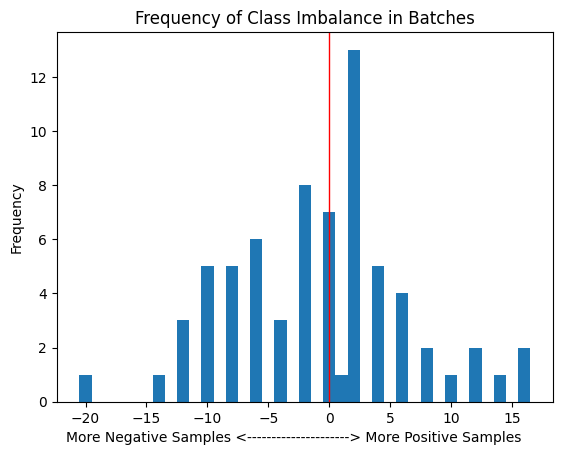

In [3]:
# Prep Data

# Set seed
torch.manual_seed(0)

# Make dataset
dataset = EEGDataset(box_data)

# Even out class distribution by downsampling
dataset.downsample()

# Split into train and test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Verify data is loaded correctly
print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))
print("Train loader size:", len(train_loader))
print("Val loader size:", len(val_loader))
print("Test loader size:", len(test_loader))
print("Sample data shape:", len(dataset))

# Display the class distribution for the training set

# Difference between positive and negative samples for each batch
differences = []

# Analyze class distribution for each batch
for _, labels in train_loader:
    positive_count = (labels == 1).sum().item()
    negative_count = (labels == 0).sum().item()
    
    # Compute the difference and append to the list
    differences.append(positive_count - negative_count)

# Plotting the histogram
fig, ax = plt.subplots()
ax.hist(differences, bins=range(min(differences), max(differences) + 2), align='left')
ax.set_xlabel('More Negative Samples <---------------------> More Positive Samples     ')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Class Imbalance in Batches')
ax.axvline(0, color='red', linewidth=1)  # Draw a vertical line at zero for reference

plt.show()

In [4]:
# Print the dataloaders to a file using pickle
filepath = "C:/Users/c25th/code/P300_BCI_Speller/"
date = datetime.datetime.now().strftime("%Y-%m-%d")

train_filename = "data/dataloaders/train_loader_"+str(date)+".txt"
val_filename = "data/dataloaders/val_loader_"+str(date)+".txt"
test_filename = "data/dataloaders/test_loader_"+str(date)+".txt"

with open(train_filename, 'wb') as f:
    pickle.dump(train_loader, f)

with open(val_filename, 'wb') as f:
    pickle.dump(val_loader, f)

with open(test_filename, 'wb') as f:
    pickle.dump(test_loader, f)